In [13]:
import os
import math as m
import numpy as np
import pandas as pd
from scipy import *
import scipy.linalg
import warnings
import matplotlib.pyplot as plt

In [14]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [86]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

def InvHankelMatrix(X):
    X = X[::,::-1]
    return np.array([np.diag(X, i).mean() for i in reversed(range(-(X.shape[0]-1), X.shape[1]))])

In [112]:
DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/walk_example.csv"
data = pd.read_csv(DATA_PATH, delimiter =',').loc[:10_000-1]

In [113]:
data

,Unnamed: 0,time,X_value,Y_value,Z_value
0,0,9.9987,4.47490,-7.43422,-0.42379
1,1,10.0010,4.63053,-7.32169,-0.41660
2,2,10.0026,4.92742,-7.10860,-0.40463
3,3,10.0048,5.19558,-6.91706,-0.41660
4,4,10.0070,5.30811,-6.84763,-0.43815
...,...,...,...,...,...
9995,9995,29.9861,1.11813,-2.08062,-1.77655
9996,9996,29.9879,1.30967,-2.12612,-1.83162
9997,9997,29.9895,1.68078,-2.26498,-1.92500
9998,9998,29.9991,2.42540,-2.64089,-2.03513


In [118]:
# исследуемый временной ряд - корень из суммы квадратов показаний акселерометра по осям
data['ts'] = data[['X_value', 'Y_value', 'Z_value']].pow(2).sum(axis = 1).pow(0.5)

In [119]:
x_clear = data['ts'].values
x = data['ts'].copy().values
x[600:700] = np.random.normal(10,5,100)
x[1250:1350] = np.random.normal(10,5,100)
X = HankelMatrix(x , 250)
X.shape

(9751, 250)

In [58]:
x_new = InvHankelMatrix(X)

In [59]:
from sklearn.decomposition import KernelPCA, PCA

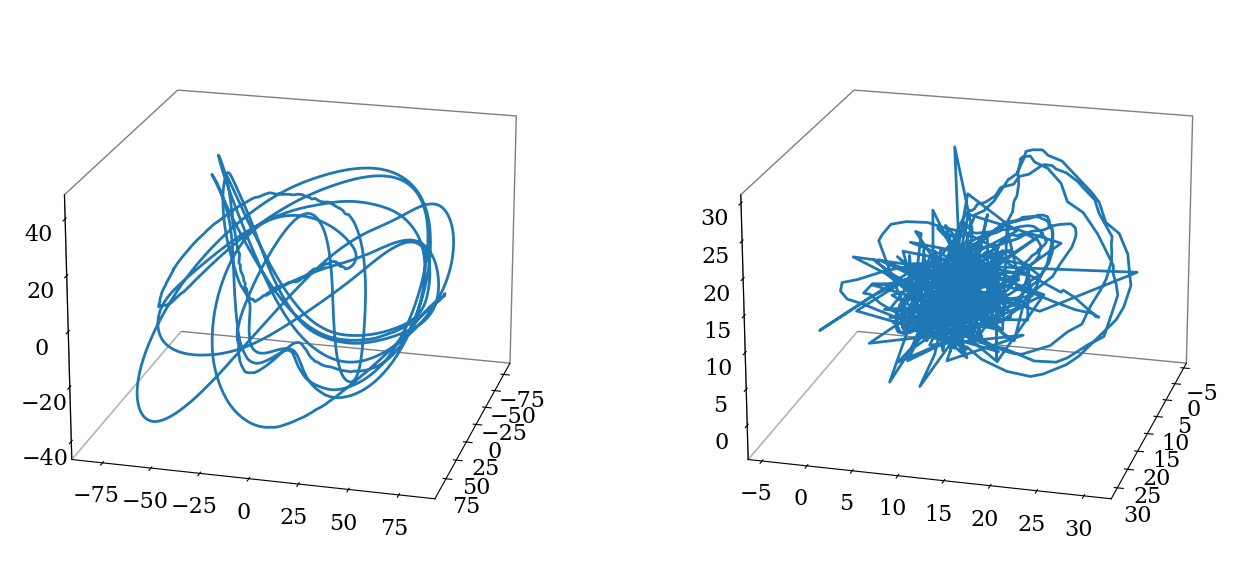

In [60]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,2,1, projection='3d')
# метод  PCA
ax.plot(
    X_PCA[:2000,0],
    X_PCA[:2000,1],
    X_PCA[:2000,2]
)

ax.view_init(elev=20, azim=15)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax2 = fig.add_subplot(1,2,2, projection='3d')
# 3 случайные точки из предыстории
ax2.plot(
    X[:2000,0],
    X[:2000,20],
    X[:2000,30]
)

ax2.view_init(elev=20, azim=15)

ax2.grid(False)
ax2.xaxis.pane.set_edgecolor('black')
ax2.yaxis.pane.set_edgecolor('black')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False


plt.show()

In [200]:
pca = PCA(n_components = 10)
X_PCA = pca.fit_transform(X)
X_rePCA = pca.inverse_transform(X_PCA)
x_new_pca = InvHankelMatrix(X_rePCA)

In [140]:
H = HankelMatrix(x_clear, 500)

In [141]:
from tqdm import tqdm

In [142]:
def HankelTensor(H, tensor_tau):
    tensor_H =  np.expand_dims(H[:tensor_tau,:],2)
    for i in tqdm(range(1,1500)):#H.shape[0] - tensor_tau + 1)):
        tensor_H = np.append(tensor_H, np.expand_dims(H[i:i+tensor_tau,:],2), axis = 2)
    return tensor_H

In [143]:
tensor_H = HankelTensor(H, tensor_tau = 50)

100%|██████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:54<00:00, 27.48it/s]


In [144]:
tensor_H.shape

(50, 500, 1500)

In [145]:
# !pip install tensorly

In [146]:
import tensorly as tl

In [147]:
from tensorly.decomposition import tucker

In [206]:
_X = tl.tensor(tensor_H)
core, factors = tucker(_X, rank=[7, 15, 15])

In [207]:
core.shape

(7, 15, 15)

In [208]:
full_tensor = tl.tucker_to_tensor((core, factors))

In [209]:
full_tensor.shape

(50, 500, 1500)

In [210]:
full_tensor[:,:,0].shape

(50, 500)

In [211]:
full_tensor.shape

(50, 500, 1500)

In [212]:
_x_new = InvHankelMatrix(full_tensor[:,:,0])[None,:]
for i in range(1, full_tensor.shape[2]):
    _x_new = np.append(_x_new, InvHankelMatrix(full_tensor[:,:,i])[None,:], axis = 0) 

In [213]:
_x_new = InvHankelMatrix(_x_new)

In [214]:
from sklearn.metrics import mean_squared_error

In [ ]:
__x_new = 

In [215]:
(
    mean_squared_error(x_clear[:1000], x_new_pca[:1000])**0.5,
    mean_squared_error(x_clear[:1000], _x_new[:1000])**0.5,
    mean_squared_error(x_clear[:1000], __x_new[:1000])**0.5,
    mean_squared_error(x[:1000], x_new_pca[:1000])**0.5,
    mean_squared_error(x[:1000], _x_new[:1000])**0.5,
    mean_squared_error(x[:1000], __x_new[:1000])**0.5
)

(2.5447078102276692,
 2.211796042956531,
 2.211796042956531,
 2.541100863754736,
 3.321353507470975,
 3.321353507470975)

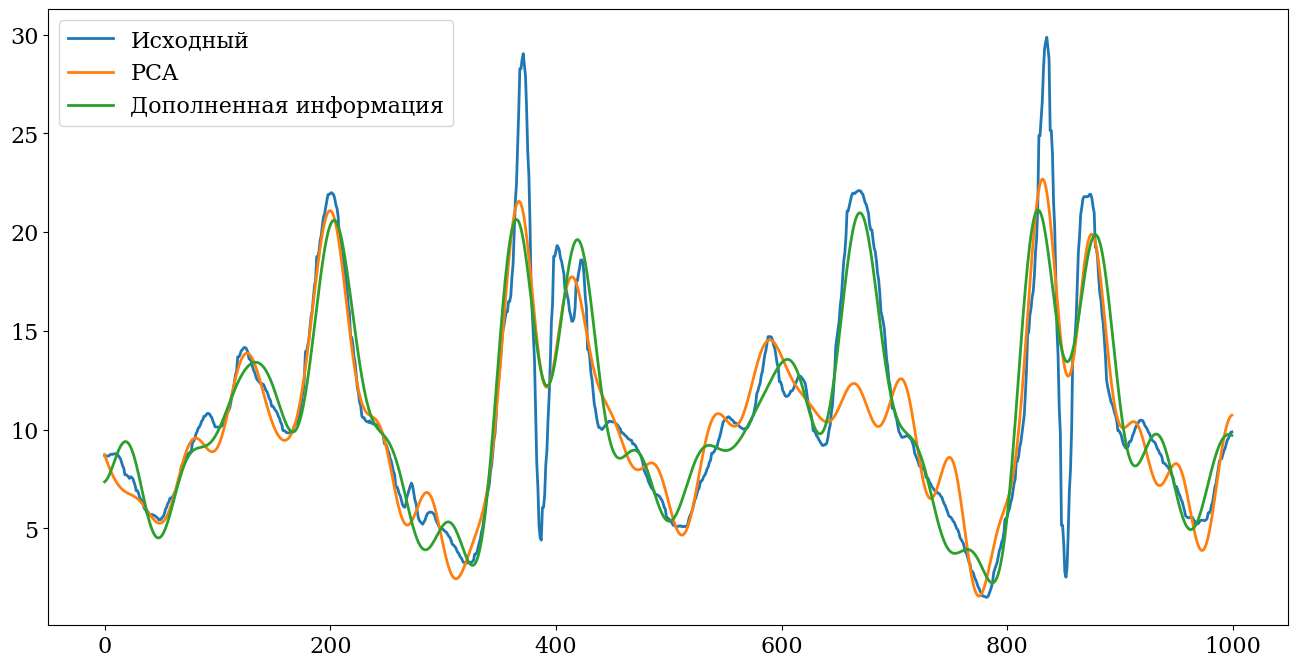

In [216]:
plt.plot(x_clear[:1000], label = 'Исходный')
plt.plot(x_new[:1000], label = 'PCA')
plt.plot(_x_new[:1000], label = 'Дополненная информация')
plt.legend()